## 확률적 경사 하강법 (Stochastic Gradient Descent; SGD)

In [4]:
class SGD:
    """확률적 경사 하강법 (Stochastic Gradient Descent)"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## 모멘텀(Momentum)을 사용한 SGD

In [5]:
import numpy as np


class Momentum:
    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## Adagrad

In [6]:
class AdaGrad:
    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## Adam (Adaptive Moment Estimation) -> RMSprop + Momentum

In [7]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = (
            self.lr
            * np.sqrt(1.0 - self.beta2**self.iter)
            / (1.0 - self.beta1**self.iter)
        )

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## Optimizer 비교

===========iteration:0===========
SGD:2.3300147581504915
Momentum:2.3781819334426726
AdaGrad:2.074463922357662
Adam:2.201466740199691
===========iteration:100===========
SGD:1.5143550970126536
Momentum:0.4012267829500191
AdaGrad:0.16584388661617816
Adam:0.25654785064165986
===========iteration:200===========
SGD:0.7946410112456324
Momentum:0.2304567284651518
AdaGrad:0.15303389695711656
Adam:0.18972947907992743
===========iteration:300===========
SGD:0.5762476114113
Momentum:0.23729657580113775
AdaGrad:0.09926010803620419
Adam:0.14202041196343246
===========iteration:400===========
SGD:0.48279067279967586
Momentum:0.19016930709712254
AdaGrad:0.0826344028599137
Adam:0.10171057535842477
===========iteration:500===========
SGD:0.45653590970465646
Momentum:0.191378337905046
AdaGrad:0.08915586576687255
Adam:0.13160201064612048
===========iteration:600===========
SGD:0.3375603755737379
Momentum:0.1125983615718266
AdaGrad:0.048298780125702656
Adam:0.07178424483557871
===========iteration:700==

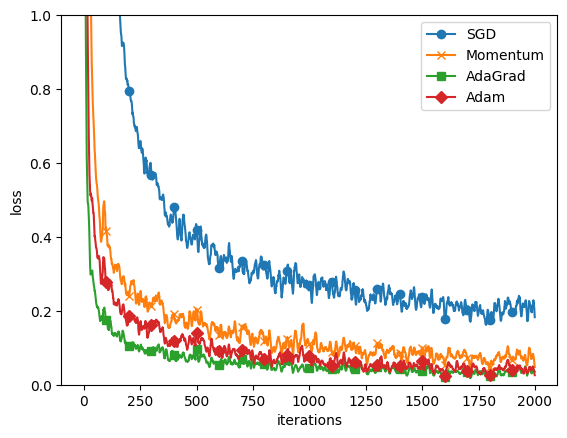

In [8]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers["SGD"] = SGD()
optimizers["Momentum"] = Momentum()
optimizers["AdaGrad"] = AdaGrad()
optimizers["Adam"] = Adam()
# optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10
    )
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(
        x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key
    )
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()